In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import time

warnings.filterwarnings("ignore")

%matplotlib inline
pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_columns = 100

# carregando do csv

In [2]:
start = time.time()
data_train = pd.read_csv('input/train_processed.csv')
print('{:.2f}s to load train data'.format(time.time()-start))

13.48s to load train data


# resumos

### clicks seguidos de download

In [3]:
data_train[data_train['is_attributed']==1].describe().drop(columns=['is_attributed'])

,hour,ip_app_clicks,ip_os_app_clicks,ip_channel_app_clicks,ip_clicks,ip_os_clicks,ip_channel_clicks,ip_os_hour_clicks,ip_hour_clicks
count,43391.00000,43391.00000,43391.00000,43391.00000,43391.00000,43391.00000,43391.00000,43391.00000,43391.00000
mean,12.49006,284.16423,42.93916,69.94135,9515.06810,762.22595,140.91187,115.40757,1431.12221
std,1.53045,2479.78508,382.93753,585.92973,48998.29636,5764.43148,1126.50055,937.41514,7972.45201
min,10.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
25%,11.00000,1.00000,1.00000,1.00000,2.00000,1.00000,1.00000,1.00000,2.00000
50%,13.00000,2.00000,2.00000,2.00000,18.00000,2.00000,2.00000,2.00000,5.00000
75%,14.00000,7.00000,3.00000,4.00000,755.00000,18.00000,7.00000,5.00000,98.00000
max,15.00000,63600.00000,12856.00000,19947.00000,389044.00000,79791.00000,30148.00000,17606.00000,83988.00000


### clicks não seguidos de downloads

In [4]:
data_train[data_train['is_attributed']==0].describe().drop(columns=['is_attributed'])

,hour,ip_app_clicks,ip_os_app_clicks,ip_channel_app_clicks,ip_clicks,ip_os_clicks,ip_channel_clicks,ip_os_hour_clicks,ip_hour_clicks
count,18446998.00000,18446998.00000,18446998.00000,18446998.00000,18446998.00000,18446998.00000,18446998.00000,18446998.00000,18446998.00000
mean,12.66962,1769.74364,195.55266,437.67746,18453.89170,1899.90665,642.30083,298.15026,2742.86051
std,1.59352,6168.36806,887.39946,1576.50159,57435.38325,7951.10706,2251.13713,1277.51246,9084.64315
min,10.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
25%,11.00000,38.00000,4.00000,6.00000,617.00000,42.00000,11.00000,13.00000,81.00000
50%,13.00000,138.00000,14.00000,22.00000,1967.00000,147.00000,39.00000,33.00000,244.00000
75%,14.00000,576.00000,60.00000,113.00000,7126.00000,623.00000,183.00000,103.00000,992.00000
max,16.00000,63600.00000,12856.00000,19947.00000,389044.00000,79791.00000,30148.00000,17606.00000,83988.00000


## distribuições das variáveis

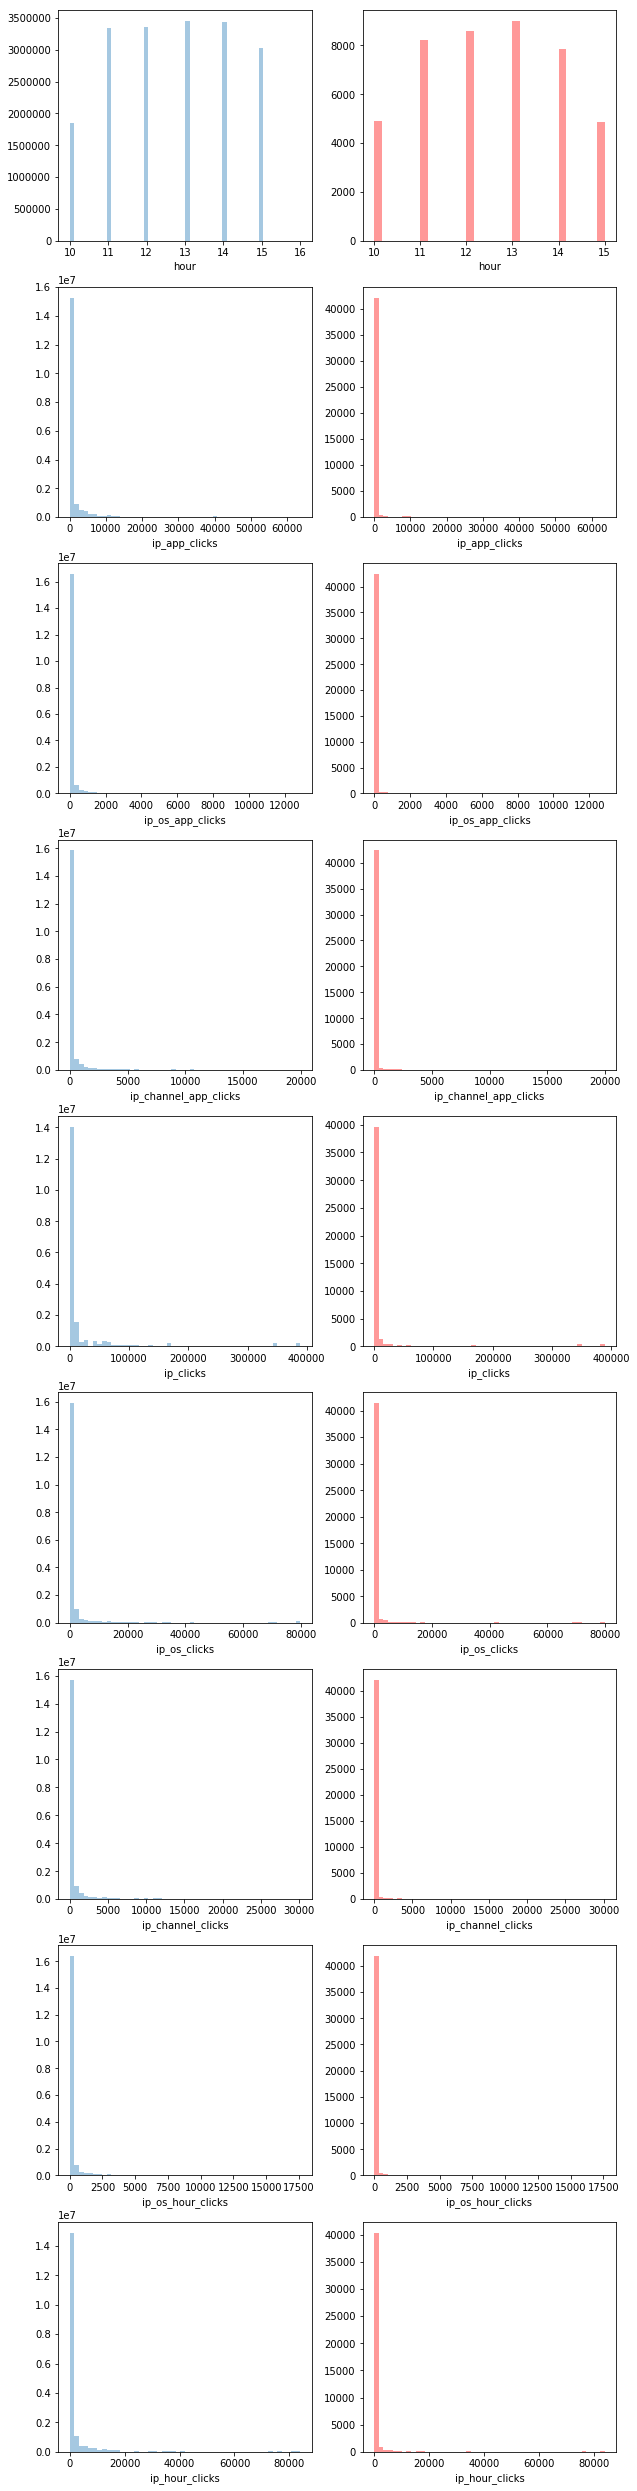

In [5]:
fig = plt.figure(figsize=(10,5*len(data_train.columns)))
count = 1
for column in data_train.columns:
    if column=='is_attributed':
        continue
    fig.add_subplot(data_train.shape[1], 2, count)
    sns.distplot(data_train[data_train['is_attributed']==0][column], kde=False)
    count += 1
    fig.add_subplot(data_train.shape[1], 2, count)
    sns.distplot(data_train[data_train['is_attributed']==1][column], kde=False, color='red')
    count += 1